Importando os módulos necessários

In [ ]:
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras import layers
from keras import metrics
from keras import losses
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import datetime
import matplotlib.pyplot as plt
import random
from math import ceil
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import pandas as pd
from random import choice


Constantes e configurações do modelo

In [ ]:
IMG_SIZE = 224
labels = ['PNEUMONIA', 'NORMAL']
BATCH_SIZE = 32
EPOCHS = 100

# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Bottom Hat Filter
kernel = np.ones((5, 5), np.uint8)

# Aumento de contraste
GAMMA = 1.3
invGamma = 1.0 / GAMMA
table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

Construindo a representação vetorial e pre processando as imagens

In [ ]:
def getDataFrom(dir_name: str, transformations:list=[]) -> list[tuple]:
  data:list[tuple] = list()
  for label in labels:
    path = os.path.join(dir_name, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resize_img = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        for transformation in transformations:
          if transformation == 'equalize':
            resize_img = cv2.equalizeHist(resize_img) # Equalização de Histograma
          elif transformation == 'gaussian':
            resize_img = cv2.GaussianBlur(resize_img, (3, 3), 0) # Filtro gaussiano
          elif transformation == 'contrast':
            resize_img = cv2.LUT(resize_img, table) # Aumento de contraste
          elif transformation == 'clahe':
            resize_img = clahe.apply(resize_img)
          elif transformation == 'bhf':
            resize_img = cv2.morphologyEx(resize_img, cv2.MORPH_BLACKHAT, kernel)
          elif transformation == 'median':
            resize_img = cv2.medianBlur(resize_img, 3)
          elif transformation == 'avarage':
            resize_img = cv2.blur(resize_img, (3, 3))
        data.append((resize_img, class_num))
      except Exception as e:
        print('Erro: ', e)
  return data

Fazendo o upload dos dados

In [ ]:
transformations = []
#transformations.append('avarage')
#transformations.append('equalize')
#transformations.append('gaussian')
#transformations.append('clahe')
#transformations.append('median')
#transformations.append('contrast')

train = getDataFrom('/content/drive/MyDrive/d.IAgnostica - Livros/PNEUMONIA/PNEUMONIA/chest_xray distribuida/train', transformations)
test = getDataFrom('/content/drive/MyDrive/d.IAgnostica - Livros/PNEUMONIA/PNEUMONIA/chest_xray distribuida/test', transformations)
val = getDataFrom('/content/drive/MyDrive/d.IAgnostica - Livros/PNEUMONIA/PNEUMONIA/chest_xray distribuida/val', transformations)

Criando e pre processando as imagens que serão usadas para treinar o modelo

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

In [ ]:
print(f'Imagens para treino:    {x_train.shape[0]}')
print(f'Imagens para validação: {x_val.shape[0]}')
print(f'Imagens para teste:     {x_test.shape[0]}')

Imagens para treino:    4192
Imagens para validação: 1040
Imagens para teste:     624


Fazendo o processo de data augmentation

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset
datagen = ImageDataGenerator(
        rotation_range=5,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
      )
datagen.fit(x_train)

Criando o modelo

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))

model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))

model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))

model.add(layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))

# Adicionado
model.add(layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))

model.add(layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))

model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1, activation='sigmoid'))

metrics_arr = ['accuracy', metrics.Recall(), metrics.Precision()]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_arr)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      2

Treinando o modelo

In [ ]:
FILE_PATH = '/content/drive/MyDrive/d.IAgnostica - Livros/2 - segundos modelos (aprimoramentos)/model-{epoch:02d}-{val_accuracy:.4f}-27092023.h5'

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=8,
                               verbose=1,
                               restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=FILE_PATH,
                             monitor='val_accuracy')

steps_per_epoch = ceil(x_train.shape[0] / BATCH_SIZE)

history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=datagen.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction, early_stopping, checkpoint],
                    steps_per_epoch=steps_per_epoch)

Epoch 1/100
131/131 [==============================] - 27s 205ms/step - loss: 0.0675 - accuracy: 0.9750 - recall: 0.9529 - precision: 0.9502 - val_loss: 0.4896 - val_accuracy: 0.8077 - val_recall: 0.9663 - val_precision: 0.5746 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 29s 219ms/step - loss: 0.0615 - accuracy: 0.9795 - recall: 0.9686 - precision: 0.9527 - val_loss: 0.2195 - val_accuracy: 0.9106 - val_recall: 0.9064 - val_precision: 0.7806 - lr: 0.0010
Epoch 3/100
131/131 [==============================] - 26s 198ms/step - loss: 0.0583 - accuracy: 0.9788 - recall: 0.9584 - precision: 0.9593 - val_loss: 1.6912 - val_accuracy: 0.7462 - val_recall: 0.0112 - val_precision: 1.0000 - lr: 0.0010
Epoch 4/100
131/131 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9728 - recall: 0.9547 - precision: 0.9408
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 25s 193ms/step - loss: 0.0658 - accuracy: 0.9728 - recall: 0.9547 - precision: 0.9408 - val_loss: 0.2962 - val_accuracy: 0.9029 - val_recall: 0.6217 - val_precision: 1.0000 - lr: 0.0010
Epoch 5/100
131/131 [==============================] - 27s 202ms/step - loss: 0.0446 - accu

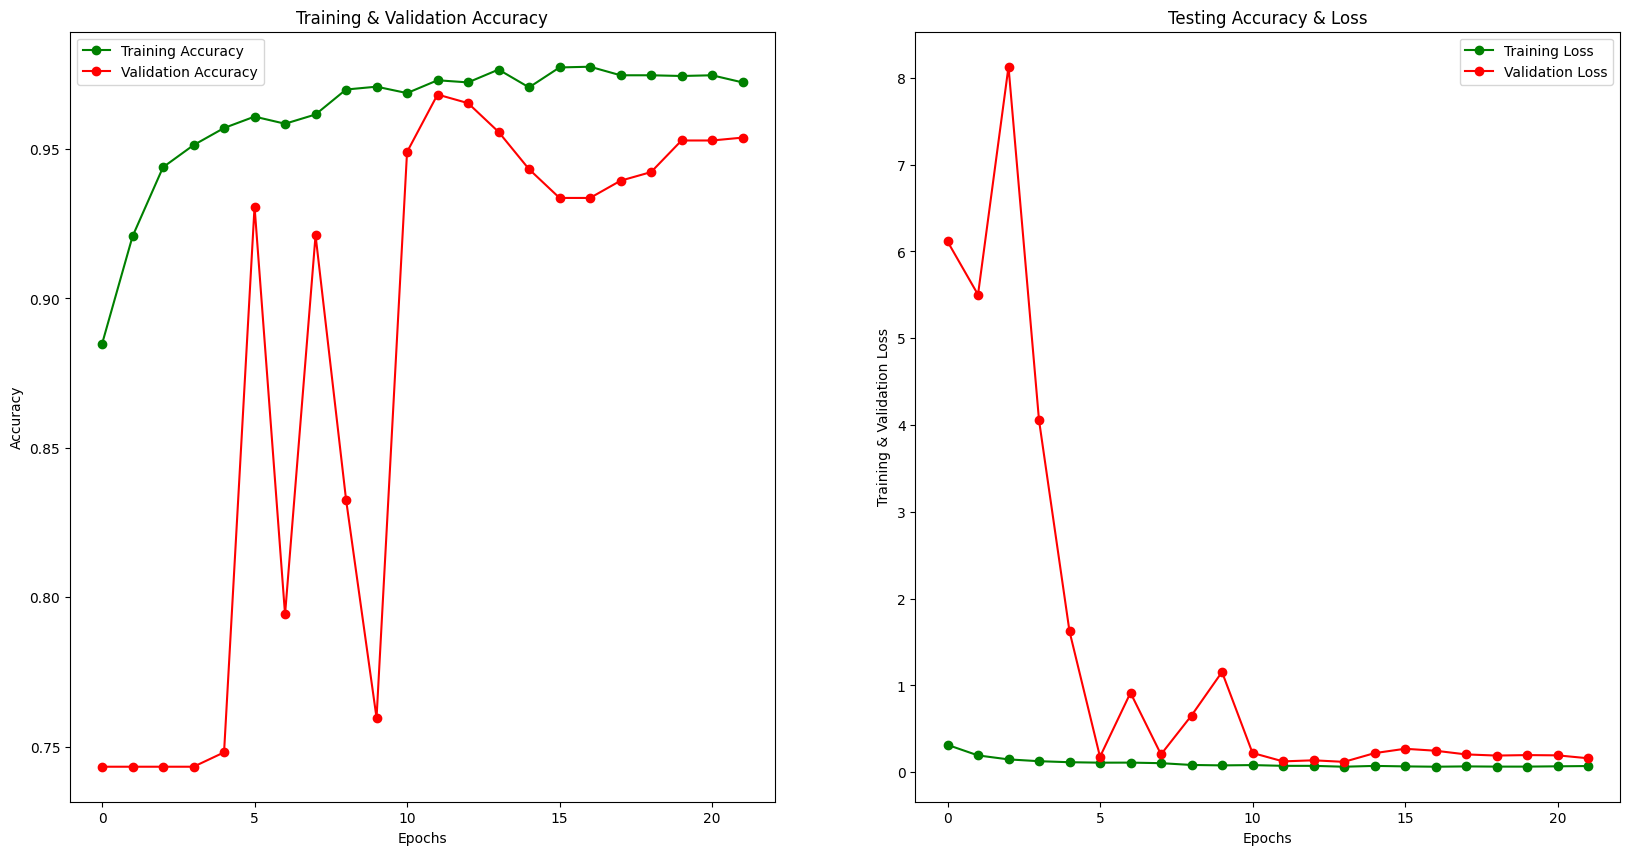

In [ ]:
epochs = [i for i in range(len(history.epoch))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

#Histórico:

|Model|Loss|Accuracy|Recall|Precision|Especificidade|
|:---:|:---:|:---:|:---:|:---:|:---:|
|model-10-0.9644.h5|0.2643|0.9103|0.8590|0.8973|
|model-09-0.9577.h5|0.2634|0.9135|0.8761|0.8913|
|model-16-0.9635.h5|0.2569|0.9135|0.8761|0.8913|0.9974|
|model-16-0.9635.h5|0.2569|0.9135|0.8761|0.8913|0.9974|
|model-11-0.9519.h5|0.2714|0.9135|0.8846|0.8846|0.9923|
|***aumento de luminosidade***|
|model-11-0.9510.h5|0.2622|0.9183|0.8333|0.9420|1.0000|
|model-09-0.9192.h5|0.2392|0.9151|0.8675|0.9022|0.9949|
|***aumento de contraste e luminosidade***|
|model-10-0.9413.h5|0.2651|0.9247|0.8590|0.9349|0.9949|
|model-12-0.9192.h5|0.2525|0.8958|0.9145|0.8263|0.9897|
|model-07-0.9442.h5|0.2249|0.9167|0.8803|0.8957|0.9949|
|***aumento de contraste***|
|model-13-0.9567.h5|0.2260|0.9199|0.8718|0.9107|0.9949|

Avaliando e salvando o modelo o modelo

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/d.IAgnostica - Livros/2 - segundos modelos (aprimoramentos)/model-21-0.9808-27092023.h5'
trainModel = load_model(MODEL_PATH)

In [ ]:
trainModel.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)

In [ ]:
predictions = trainModel.predict(x_test)
predictions = predictions.reshape(1,-1)[0]

20/20 [==============================] - 1s 19ms/step


In [ ]:
classes = []
for prediction in predictions:
  if prediction <= 0.5:
    classes.append(0)
  else:
    classes.append(1)

cm = confusion_matrix(y_test, classes)
print(cm)
print(f'{cm[0][1]} + {cm[1][0]} = {cm[0][1] + cm[1][0]}')

[[384   6]
 [ 27 207]]
6 + 27 = 33


In [ ]:
total = sum(sum(cm))
vp = cm[0][0]
fn = cm[0][1]
fp = cm[1][0]
vn = cm[1][1]

acuracia = (vp + vn) / total
precisao = vp / (vp + fp)
recall = vp / (vp + fn)
f1 = (2 * precisao * recall) / (precisao + recall)

print(f'Sensibilidade: {recall:.4f}'.replace('.', ','))
print(f'F1 - Score:    {f1:.4f}'.replace('.', ','))
print(f'Acurácia:      {acuracia:.4f}'.replace('.', ','))
print(f'Precisão:      {precisao:.4f}'.replace('.', ','))

Sensibilidade: 0,9846
F1 - Score:    0,9588
Acurácia:      0,9471
Precisão:      0,9343


In [ ]:
index_erros = []

for i in range(len(classes)):
  if y_test[i] != classes[i]:
    index_erros.append(i)

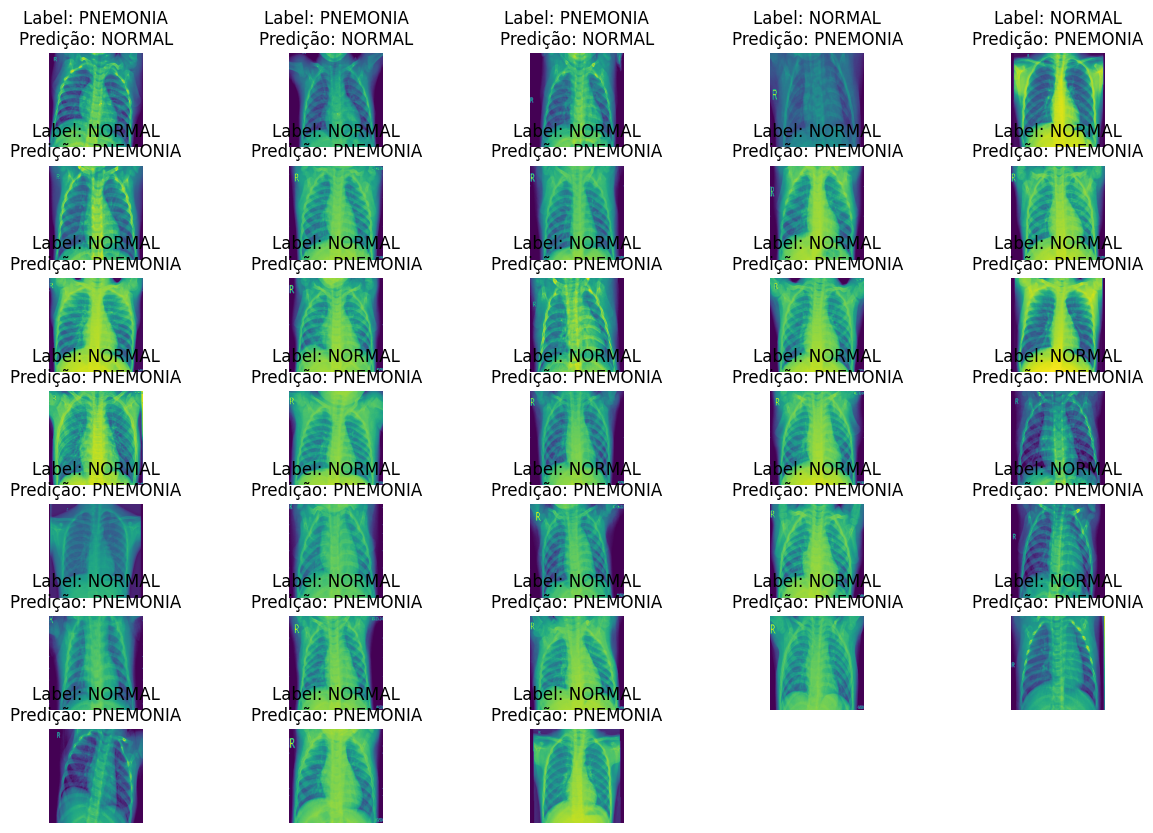

In [ ]:
fig = plt.figure(figsize=(15, 10))

linhas = 7
colunas = 5
for i in range(1, linhas*colunas + 1):
  if i <= 33:
    index_img = index_erros[i-1]
    img_random = x_test[index_img]
    label_img = y_test[index_img]
    predic_img = classes[index_img]

    subtrama = fig.add_subplot(linhas, colunas, i)
    subtrama.imshow(img_random)

    label_name = 'PNEMONIA'
    if label_img == 1: label_name = 'NORMAL'
    predic_name = 'PNEMONIA'
    if predic_img == 1: predic_name = 'NORMAL'

    subtrama.set_title(f'Label: {label_name}\nPredição: {predic_name}')
    subtrama.axis('off')

plt.show()

In [ ]:
print(classification_report(y_test, classes, target_names = ['Pneumonia (Classe 0)','Normal (Classe 1)']))

                      precision    recall  f1-score   support

Pneumonia (Classe 0)       0.93      0.95      0.94       390
   Normal (Classe 1)       0.92      0.88      0.90       234

            accuracy                           0.92       624
           macro avg       0.92      0.91      0.92       624
        weighted avg       0.92      0.92      0.92       624



<Axes: >

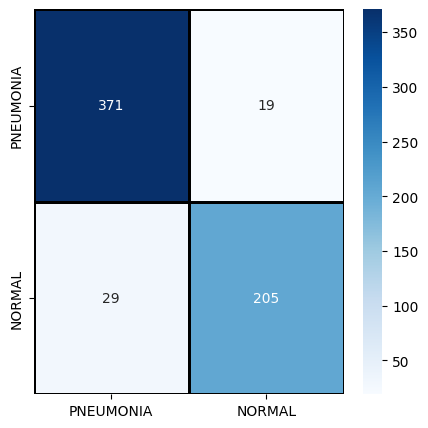

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

Teste automático dos modelos.

In [ ]:
def calcularMetricas(matriz_confusao) -> tuple:
  total = sum(sum(matriz_confusao))
  vp = matriz_confusao[0][0]
  fn = matriz_confusao[0][1]
  fp = matriz_confusao[1][0]
  vn = matriz_confusao[1][1]

  acuracia = (vp + vn) / total
  precisao = vp / (vp + fp)
  recall = vp / (vp + fn)
  f1 = (2 * precisao * recall) / (precisao + recall)

  return (acuracia, recall, precisao, f1)

def result_class(predictions: list) -> list:
  class_predictions = []
  for prediction in predictions:
    if prediction <= .5:
      class_predictions.append(0)
    else:
      class_predictions.append(1)
  return class_predictions

def testarModelos(dir: str, imgs_teste: list, labels_teste: list) -> list[dict]:
  resultados: list[dict] = list()
  for model_name in os.listdir(dir):
    if '.h5' in model_name:
      model_path = os.path.join(dir, model_name)
      model = load_model(model_path)

      predictions = model.predict(imgs_teste)
      predictions = predictions.reshape(1,-1)[0]

      class_predictions = result_class(predictions)

      cm = confusion_matrix(labels_teste, class_predictions)
      acc, sen, prec, f1 = calcularMetricas(cm)

      metricas = dict()
      metricas['nome_modelo'] = model_name[:-3]
      metricas['sensibilidade'] = sen
      metricas['f1-score'] = f1
      metricas['acuracia'] = acc
      metricas['precisao'] = prec

      resultados.append(metricas)
  return resultados

In [ ]:
resultados = testarModelos('/content/drive/MyDrive/d.IAgnostica - Livros/2 - segundos modelos (aprimoramentos)', x_test, y_test)

20/20 [==============================] - 0s 17ms/step


In [ ]:
primeiro = True
for resultado in resultados:
  if primeiro:
    for key in resultado:
      print(f'{key:^25}', end='')
    print()
    primeiro = False

  if resultado['f1-score'] >= 0.94:
    for key in resultado:
        if type(resultado[key]) == str:
          print(f'{resultado[key]:^25}', end='')
        else:
          print(f'{resultado[key]:^25.4f}'.replace('.', ','), end='')
    print()

       nome_modelo             sensibilidade              f1-score                 acuracia                 precisao         
model-06-0.9740-27092023          0,9923                   0,9567                   0,9439                   0,9236          
model-07-0.9663-27092023          0,9769                   0,9525                   0,9391                   0,9293          
model-09-0.9692-27092023          0,9923                   0,9405                   0,9215                   0,8938          
model-10-0.9673-27092023          0,9923                   0,9451                   0,9279                   0,9021          
model-11-0.9760-27092023          0,9872                   0,9553                   0,9423                   0,9255          
model-12-0.9837-27092023          0,9872                   0,9565                   0,9439                   0,9277          
model-13-0.9788-27092023          0,9846                   0,9588                   0,9471                   0,9343   